In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_validate, KFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

D:\Anaconda\lib\site-packages\distributed\utils.py:133: RuntimeWarning:

Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [WinError 10065] A socket operation was attempted to an unreachable host



***

In [2]:
# Read train and test dataset
df_train = pd.read_csv('data.csv')
df_test = pd.read_csv('test.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(616656, 20)
(154165, 19)


In [4]:
# Keep last index of training dataset
last_index = df_train.shape[0]

In [5]:
# Add new column for test dataset
df_test['Market Share_total'] = 0.0

In [6]:
# Merge train and test dataset into one dataframe
pieces = {'train': df_train, 'test': df_test}
df = pd.concat(pieces, sort=False, ignore_index=True)

In [43]:
df[last_index-1:last_index+2]

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,...,Temperature,Day,Month,Temp-binned,Length-binned,Weekend?,Time of start,avg_prv_target,max_prv_target,std_prv_target
616655,616656,Mom V.F. (M),VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,11:00:00,11:30:00,...,-22.525,22,1,"(-27, -15]","(0, 18]",No,Morning,0.0,0.0,0.0
616656,1,Mom V.F. (M),VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,11:30:00,12:00:00,...,-22.525,22,1,"(-27, -15]","(0, 18]",No,Morning,0.0,0.0,0.0
616657,2,2 filles fauchées,VRAK+,Specialty Channel,Winter,2019,2019-01-22,Tuesday,12:00:00,12:30:00,...,-21.625,22,1,"(-27, -15]","(0, 18]",No,Afternoon,0.0,0.0,0.0


In [8]:
df.rename(columns = {"Market Share_total": "Target", 
                     "Temperature in Montreal during episode": "Temperature",
                     "Game of the Canadiens during episode?": "Any game?", 
                     "First time or rerun": "First time?",
                     "# of episode in the season": "Episodes?"},
         inplace=True)

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

# Create new columns: "Month" and "Day" from "Date" Column
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

# Extract time from "Start_time"
df['Start_time'] = pd.to_datetime(df['Start_time']).dt.time

# Extract time from "End_time"
df['End_time'] = pd.to_datetime(df['End_time']).dt.time

In [10]:
df.isnull().sum()

Unnamed: 0              0
Episode                 0
Station                 0
Channel Type            0
Season                  0
Year                    0
Date                    0
Day of week             0
Start_time             65
End_time               65
Length                  0
Name of show            0
Name of episode    253198
Genre                   0
First time?             0
Episodes?               0
Movie?                  0
Any game?               0
Target                  0
Temperature        106573
Day                     0
Month                   0
dtype: int64

In [11]:
df.drop('Name of episode', axis=1, inplace=True)

In [12]:
indices = df[df['Start_time'].isnull()]['Start_time'].index
for i in indices:
    df.at[i, ['Start_time']] = dt.datetime.strptime('03:00:00', '%H:%M:%S').time()

In [13]:
indices = df[df['End_time'].isnull()]['End_time'].index
for i in indices:
    df.at[i, ['End_time']] = dt.datetime.strptime('03:00:00', '%H:%M:%S').time()

In [14]:
indices = df[df['Temperature'].isnull()]['Month'].index
months = df[df['Temperature'].isnull()]['Month'].values
mean_temps = df['Temperature'].groupby(df['Month']).mean()

for i,month in enumerate(months):
    df.at[indices[i], 'Temperature'] = mean_temps[month]

In [15]:
df.isnull().sum()

Unnamed: 0      0
Episode         0
Station         0
Channel Type    0
Season          0
Year            0
Date            0
Day of week     0
Start_time      0
End_time        0
Length          0
Name of show    0
Genre           0
First time?     0
Episodes?       0
Movie?          0
Any game?       0
Target          0
Temperature     0
Day             0
Month           0
dtype: int64

---

In [16]:
# Binning Temperature column into some Interval
temp = df['Temperature']
bw = int( (max(temp) - min(temp)) / 5 )
bins = range(int(min(temp)), int(max(temp)), bw)
df['Temp-binned'] = pd.cut(temp, bins)

# Binning Length column into some Interval
leng = df['Length']
bw = int( (max(leng) - min(leng)) / 5 )
bins = range(int(min(leng)), int(max(leng)), bw)
df['Length-binned'] = pd.cut(leng, bins)

In [17]:
df['Weekend?'] = ['Yes' if (row == 'Sunday' or row == 'Saturday') else 'No' 
                  for row in df['Day of week']]

In [18]:
df['Time of start'] = ['Morning' if (row >= dt.time(6) and row < dt.time(12)) 
                       else 'Afternoon' if (row >= dt.time(12) and row < dt.time(16))
                       else 'Evening' if (row >= dt.time(16) and row < dt.time(20))
                       else 'Night' if (row >= dt.time(20) and row < dt.time(23,55,0))
                       else 'Midnight'
                       for row in df['Start_time']]

In [20]:
df['avg_prv_target'] = 0.0
df['max_prv_target'] = 0.0
df['std_prv_target'] = 0.0

df_train = df[:last_index]
serials = df_train.groupby(df_train['Name of show']).size().index

cnt = 0
for serial in serials:
    cnt = cnt + 1
    print(cnt, serial)
    
    inds = df_train[df_train['Name of show'] == serial]['Target'].index
    vals = df_train[df_train['Name of show'] == serial]['Target'].values
    for i in range(1,len(inds)):
        df.at[inds[i], 'avg_prv_target'] = round(np.mean(vals[0:i]),2)
        df.at[inds[i], 'max_prv_target'] = round(np.max(vals[0:i]),2)
        df.at[inds[i], 'std_prv_target'] = round(np.std(vals[0:i]),2)
    print("=================")

#5règles
#5règles (M)
#BITCH - LES FILLES ET LA VIOLENCE
#Bitch - les filles et la violence
#TamyUSA
#danslatoile
+3 degrés
1, 2, 3... Géant
1, 2, 3... Géant - FT
100 % Justice
100 Jours
100 ans à table
100% Animal
100% NOUVELLES
100% Révélations
100% local
100% révélations
100% révélations 2018
1000 jours pour la planète
1001 nuits
1001 vies
100e anniversaire de la bataille de Vimy
100e anniversaire de la bataille de la crête de Vimy
13 h 15 le dimanche
13 h 15 le samedi
13h15 le samedi
16 ans et enceinte
16e grande guignolée des médias
17 ans et maman
180 jours
1res fois
1res fois - Best
2 filles fauchées
2 filles fauchées (M)
2016 : ça se discute
2016 vue par Découverte
2016 vue par Découverte - prog loc
2016 vue par Enquête
2016 vue par Enquête - prog loc
2017 selon Code F. et Code G.
2050 dans votre assiette
21 Thunder : L'équipe du Tonnerre
21 jours
21e, Le
21ème siècle
22 Mars Ensemble
24 h en 60 minutes
24 heures : danger !
24 heures chrono
24 heures en 60 min
24 heures en 60 m

ALVINNN!!! et Les Chipmunks
ANIMAL CHERCHE COMPAGNIE... POUR LA VIE
ANTHONY KAVANAGH JOUE À DOMICILE
APB alerte d'urgence
APPÂT, L'
APRES-MIDI 12P-7P
ARCTIQUE
ARRIVE EN CAMPAGNE
ARTIS, LE GALA
ARTIS, LE TAPIS ROUGE
ARTIS, LES COULISSES
ARTV - lumière sur ...
AU NOM DE JÉHOVAH
AU SECOURS DE BÉATRICE
AUTO CHALLENGE XTREM
AUTO FORMULE E MTL
AZIMUT, le mag télé 100% voyage
Aberdeen : au coeur de la création
Académie Airoldi
Accident de star
Accouchements extrêmes
Accusé
Accès illimité
Accès illimité à Céline
Achète, retape, revends!
Acoustic
Acquitté
Adam recherche Eve
Adam recherche Eve - Allemagne
Adam recherche Ève
Adib Alkhalidey - Je t'aime
Ados et libido
Adventure Time
Adventure Time (Fr)
Affaire O.J. L' - American Crime Story
Affaire OJ Simpson, L'
Affaires judiciaires de 2016, Les
Affaires qui roulent
Afghanistan, 15 ans après, L'
Africanités
Agatha Raisin
Agents doubles
Agrofolie
Agrofun
Aidan Black
Ailleurs l'espoir
Aimer à mort
Ainsi soient-ils
Al dente
Alaska : La ruée vers l'o

Argonautes, Les
Ari cui cui
Ariol
Arnaque en ville
Arrange-toi avec ça
Arrange-toi avec ça (M)
Arrow
Art de la table, L'
Art érotique
Art érotique, L'
Arthur
Arthur aventure Afrique
Arthur et les Minimoys
Arthur et les enfants de la table ronde
Arthur l'aventurier
Arthur l'aventurier au Costa Rica
Arthur l'aventurier en Afrique
Arthur l'aventurier à la découverte des rocheuses
Artistes en vedette
Artéfacts sous la loupe
As de la Jungle : Drôle d'oiseau
As de la Jungle, Les
As de la jungle, Les
Ascension
Assermentation de Donald Trump
Astérix & Obélix
Atelier de restauration, L'
Ateliers du goût, Les
Atlantis
Atomes crochus
Atomic Betty
Atomic Puppet
Atomic Puppet (Fr)
Attaques à main armée
Attentat Qc 1 an - TJ 18h30
Attentat de Québec, un an après
Attractions épiques
Au bout du lac
Au coeur de la tempête
Au coeur des parcs nationaux
Au coeur du Yukon
Au nom de Jéhovah
Au pays des Cajuns
Au pays des Mitchifs
Au pays des Têtes à claques
Au pays des têtes à claques
Au pays du Père Noël
A

BD QC
BEAUX MALAISES, LES
BIEN
BLITZ - R
BLOOPERS - LES CLASSIQUES
BLOOPERS TVA
BLUE MOON
BONHEUR D'ADOPTION
BOOMERANG
BOUFFE MTL
Backstage : Les coulisses du succès
Backstage : Les coulisses du succès (M)
Bad Ink
Bad Ink (M)
Bagages
Bagages aux enchères
Bagel et Becky
Baiser fatal
Balade
Balade sous-marine
Balade à Toronto
Bali
Ballers
Ballet Casse-Noisette
Banc public
Banc public nuit
Banquier, Le
Banquier, Le - Halloween
Banshee
Barmaids
Baseball MLB
Baseball MLB - R
Baseball MLB Compétition de circuits
Baseball MLB Match des Étoiles
Baseball MLB Série Mondiale
Baseball MLB Série Mondiale - R
Baseball MLB Série de Championnat
Baseball MLB Série de Championnat Blue Jays:
Baseball MLB Séries de Division
Baseball MLB des Blue Jays:
Baseball MLB éliminatoires
Baseball MLB éliminatoires - R
Baseball Magazine - R
Baseball Série de Championnat - R
Baseball magazine
Basketball
Basketball NBA
Basketball NBA - R
Basketball NBA Raptors
Basketball NBA éliminatoires
Basketball de la NBA - R
Bask

Boucle, La
Bouffe de malade
Bouffe en cavale
Bouffons
Bouffons de rue
Bougaricci
Bougon, Les
Bouiing
Boule et Bill
Boule et Bill 3D
Bowling- Une histoire de boules
Bowling: une histoire de boules
Boxe
Boxe - R
Boxe - Toni Yoka, la conquête
Boxe en direct
Boîte à musique, La
Braqueurs
Bras de fer
Bravest Warriors
Bravest Warriors (Fr) (30 minutes)
Brico Club
Brigade animo
Briseurs de coffres-forts
Britanniques, histoire d'un peuple, Les
Broadchurch
Brokenwood
Brotherhood
Brèves de taxi
Budget du Québec
Budget du Québec 2018
Budget fédéral
Budget fédéral 2017
Budget fédéral 2018
Bugs Bunny Joyeuses Pâques
Bugs Bunny Magicien de l'amaigrissement
Bugs Bunny Spécial Saint Valentin
Bugs Bunny Spécial Saint-Valentin
Bugs Bunny Spéciale Fêtes de Mères
Bugs Bunny dans les Contes de Noël
Bugs Bunny dans les contes de Noël
Bugs Bunny et Tweety
Bugs et les Looney Tunes
Bugs!
Bugs! Une production Looney Tunes
Bull
Bunnicula
Burlesque
Buzz
Buzz capsules
Bye
Bye Bye 2016
Bye Bye 2017
Bye bye 2018
Bye

Catfish
Catherine
Cauchemar sur l'autoroute
Caïn
Ce soir tout est permis
Ceci n'est pas un talk show
Cellule de crise
Centenaire de la signature de l'armistice de la Première Gue
Centre-ville: l'âge des lumières
Ces armes qui ont changé le monde
Ces chansons qui ont fait l'histoire
Ces gars-là
Ces jours qui ont marqué l'Amérique
Ces lacs qui tutoient le ciel
Cette année-là
Cette maison en vaut la peine
Chacun son combat
Chacun son île
Chainreaction
Chair de poule
Chair de poule - les spéciaux
Chalet, Le
Chalets de l'Alberta
Chalets de la Côte Ouest
Chalets de la côte ouest
Challenge
Challenge, Le
Championnat de France de Ligue 1
Championnats du monde d'athlétisme
Championnats du monde de gymnastique artistique
Champions Factory
Champions du monde
Champions du web
Chandail, Le
Changer de sexe : la transformation
Chansons à aimer
Chaplin
Chaplin nuit
Charmed
Chasse urbaine
Chasse, La
Chasseurs d'aventures
Chasseurs d'épaves
Chasseurs de chars
Chasseurs de poids lourds
Chasseurs de voitur

Cinéma des fêtes am
Cinéma dimanche
Cinéma dimanche nuit
Cinéma en fête
Cinéma famille
Cinéma humoristique
Cinéma jeudi
Cinéma jeudi nuit
Cinéma lundi
Cinéma lundi nuit
Cinéma mardi
Cinéma mardi nuit
Cinéma mercredi
Cinéma mercredi nuit
Cinéma samedi
Cinéma samedi nuit
Cinémagie
Cinéphile
Cinéplus des fêtes
Cirque Alfonse : une affaire de famille, Le
Cirque Nikouline
Clan, Le
Clash
Clash (M)
Classe ouvrière, La
Classe à part
Classique de Noël
Classé XXX
Classé XXX (M)
Claude Gingras critique
Claude Poirier : secrets judiciaires
Claude n'est pas mort
Clem
Clic et sa bande
Cliptoman
Cloudy with a Chance of Meatballs
Club cinéma
Club doigts croisés
Clé en main
Cobaye humain
Cochon dingue
Cochon qui criait au loup-garou, Le
Cochons d'Angry Birds, Les
Code 111
Code Black
Code F.
Code F. rencontre Code G.
Code G.
Code Max
Code(s) polar
Code, Le
Colis de la Planète X
Colis de la planète X
Colonie
Combat des griffes
Combat des villes, Le
Combats Ultimes TKO - R
Commando Bigfoot
Commandos cland

Cracké
Craindre son voisin
Crakan studio présente
Crescendo
Crescendo - Meilleurs moments
Crime parfait
Crimes de l'Ouest
Crimes majeurs
Crimes sur le vif
Criminels 2.0
Criminels pas futés
Cris du coeur
Croisières de rêve
Croisée des chemins, La
Crossing Lines
Créer
Cuban Chrome
Cuisine futée, parents pressés
Cuisine futée, parents pressés nuit
Cuisinez comme Louis
Cuisinier rebelle prend l'air, Le
Cuisiné avec amour
Culture Cosplay
Culture animale
Cumulus
Cupcake et Dino: Services en tout genre
Cupidon
Cure, La
Curieux Bégin
Curieux métiers!
Curling
Curling - R
Curling-R
Cut
Cyclisme Tour France
Cyclisme Tour de France
Cyclisme Tour de France - R
Cyclisme UCI
Cyclisme UCI - R
CÉLÉBRATION 2018
CÉLÉBRATION 2019
Câlins canins
Célibataires au menu
Célibataires au menu (M)
Célibataires et nus
Célibataires et nus QC
Célibataires et nus Québec
Célibataires et nus US
Céline Galipeau rencontre Nicolas Hulot
Céline, au-delà du rêve
Célèbres et fauchés
Célébration 2017
Cérémonie d'hommage nation

Degrassi : nouvelle génération
Dehors
Demain des hommes
Demain nous appartient
Denis Lévesque
Derek
Dernier choix, Le
Dernier navire, Le
Dernier passager WIXX, Le
Dernier passager, Le
Dernières 24h de..., Les
Des Suisses à New York
Des bateaux et des hommes
Des camions et des hommes
Des camions et des hommes, les camions de l'extrême
Des chevaux, des hommes et du cash
Des chiffres et des lettres
Des enfants et des armes
Des idées de grandeur
Des idées de grandeur (M)
Des idées de grandeur dans ma cour
Des idées de grandeur dans ma cour (M)
Des idées payantes
Des jobs de fous
Des maisons insolites
Des monuments et des hommes
Des racines et des ailes
Des routes et nous au Québec
Des routes et nous au Québec (3)
Des rénos qui rapportent gros
Des rénos qui rapportent gros (M)
Des squelettes dans le placard
Des trains pas comme les autres
Des vedettes sous le sapin
Des écoles pas comme les autres
Deschampsons
Design V.I.P.
Design V.I.P. (M)
Design est partout, Le
Designers en compétition
De

Dragons : Par-delà les rives
Dragons:  Le cadeau du furie nocturne
Dre Grey
Dre Grey, leçons d'anatomie
Dre Mary: mort sur ordonnance
Dreamworks
Drones:
Drôle d'animal, Un
Drôle de blagues
Drôles de colocs
Du talent à revendre
Duel au soleil
Dundee, trappeur urbain
Duo sans limites
Durham
Dynamo
DÉFILÉ DES JUMEAUX 2017
DÉFILÉ DU PÈRE NOËL DESTINATION CENTRE-VILLE
Débat des chefs 2018
Débats : primaire de la droite et du centre
Débats : primaire de la gauche
Déchaîne-toi ou meurs !
Déco Top Chrono
Déco Top Chrono (M)
Déco top chrono
Déconstruire la ville
Décore ta vie
Décore ta vie (M)
Découverte
Défi Mondial des Moins de 17 ans
Défi aventure au Nunavik
Défi limo : Las Vegas
Défi moto à Phoenix
Défier la magie
Défier la magie - Prog loc
Défilé Fête nat.
Défilé du Père Noël destination centre-ville, Le
Défilé militaire du 14 juillet
Défilé militaire et civil belge
Défis extrêmes
Défis extrêmes: Absurdicourse, L'
Déjà dimanche
Déjà dimanche - La rentrée
Délateurs
Démolition man
Déménageur

Escapade, le magazine des patrimoines
Escortes
Escortes (M)
Escouade animale
Escouade des monstres-maths
Espace Découvertes
Espace d'une chanson, L'
Espace découvertes
Espaces autochtones
Espaces autochtones : un an déjà
Espaces maximisés
Espaces:6189 mètres d'espoir
Espaces:Au Nord du soleil
Espaces:Au delà des cimes
Espaces:Broad Peak
Espaces:Cammas, un homme pressé
Espaces:Dejame Vivir
Espaces:Holtanna, l'aventure antarctique
Espaces:Imagine 2014
Espaces:L'aventure impossible: Le fil de Darwin
Espaces:Lignes de vie
Espaces:Mont-Blanc extreme rescue:un été meurtrier
Espaces:Mont-Blanc: mortelle randonnée
Espaces:Montagnes de rêve-Eiger
Espaces:Nager au-delà des frontières
Espaces:Odyssée sibérienne
Espaces:On a survolé la terre
Espaces:Petit Bus rouge
Espaces:Pushing the limits: Le futur commence ici
Espaces:T'es pas bien là?
Espaces:Tracing Skylines - Ski :Le trip d'une vie
Espaces:Ueli Steck, coureur des sommets
Espaces:Un hiver avec les sauveteurs de Mont Blanc
Espaces:Un monde de

Football LCF
Football LCF - R
Football LCF - Repêchage
Football LCF Alouettes après-match
Football LCF Alouettes avant-match:
Football LCF Alouettes de Montréal
Football LCF Alouettes de Montréal pré-saison
Football LCF Coupe Grey - R
Football LCF Coupe Grey:
Football LCF avant-match
Football LCF avant-match Coupe Grey:
Football LCF éliminatoires
Football LCF éliminatoires - R:
Football LCF: avant-match - R
Football NCAA
Football NCAA-R
Football NFL
Football NFL - R
Football NFL Pro Bowl
Football NFL Pro Bowl - R
Football NFL Repêchage
Football NFL Superbowl
Football NFL Superbowl après-match:
Football NFL Superbowl avant-match
Football NFL avant-match Blitz
Football NFL avant-match Blitz - R
Football NFL éliminatoires
Football NFL éliminatoires - R
Football: LCF - R
Football: LCF Alouettes de Montréal - R
Football: NFL éliminatoires
Force du destin, La
Forces spéciales : entraînement extrême
Forgerons à Milwaukee
Format familial
Formule Diaz
Fort McMurray, un an après
Fort comme un ro

Galas ComédiHa!
Galas du grand rire 2008, Les
Galas du grand rire 2014, Les
Galaxie Académie
Gamers : au-delà du jeu
Gang de malades
Garage d'élite
Garde-manger
Garderie Waf Waf
Garderie extrême
Garfield & cie
Garfield : la révolution des rongeurs
Garfield et cie
Garfield tout court
Garfield: la révolte des rongeurs
Gars des vues, Les
Gars des vues, Les nuit
Gars le soir, Un
Gator Boys : Au secours des alligators
Gawayn
George de la jungle
Girls
Global Citizen : Montréal
Gold Divers : pêcheurs d'or
Goldwater à l'écoute
Golf : Au 19e
Golf Au 19e
Golf Coupe Président
Golf Coupe Ryder
Golf Coupe Sani Marc
Golf Coupe Sani Marc - R
Golf Coupe des Presidents ronde 1-2
Golf Coupe des Presidents ronde 3-4
Golf LPGA
Golf LPGA - R
Golf Omnium Britannique
Golf Omnium Britannique - R
Golf Omnium Britannique ronde 1-2
Golf Omnium Britannique ronde 3-4
Golf Omnium Canadien ronde 3-4
Golf Omnium des États-Unis
Golf Omnium des États-Unis ronde 3-4
Golf Omniun Canadien - R
Golf PGA
Golf PGA - R
Golf PG

Hantise
Happy Valley
Harley et les Davidson
Harold et la légende du Pikpoketos
Harry & Bip
Harry Styles Live In Manchester V.F.
Harry et ses dinosaures
Haute sécurité
Hawaii 5-0
Heartland
Heartland (Fr)
Heidi
Helix
Hell's Kitchen
Hell's Kitchen (18)
Henry
Henry Danger
Hep taxi !
Hep taxi!
Hercule Poirot
Heure bleue, L'
Heure est grave, mais la demi-heure est drôle, L'
Heure limite
Hexagone
Histoire de jouets
Histoire de jouets : angoisse au motel
Histoire de jouets : hors du temps
Histoire du monde, L'
Histoire vraie, Une
Histoires d'entraide
Histoires d'entraide : les préjugés
Histoires de Sentiers
Histoires de Sentiers R
Histoires de chars
Histoires en cour
Hitler déclassifié
Hockey 360
Hockey 360 - R
Hockey 360 Canadiens séries
Hockey 360 Prime
Hockey 360 avant-match
Hockey AHL IceCaps
Hockey CH Avec pas d'Match
Hockey Canadiens Express
Hockey Canadiens Express - R
Hockey Canadiens Express Hebdo
Hockey Canadiens Express Hebdo Daytime
Hockey Canadiens Express Hebdo Prime
Hockey Chall

Humour en spectacle
Humour en spectacle (M)
HÔTEL DE LUXE
HÔTEL HELL
HÔTEL IMPOSSIBLE
HÔTEL IMPOSSIBLE 5 ÉTOILES
HÔTEL IMPOSSIBLE TOP 10
Hélico tout terrain
Héritier, L'
Héros de guerre
Héros purs et durs
Hôpital vétérinaire
Hôtel Transylvanie - la série
Hôtels eXtrêmes
ICarly
IL ÉTAIT UNE FOIS
IL ÉTAIT UNE FOIS... CÉLINE
INFOPUBLICITÉ
INFRACTIONS
Ice legends
Ici Laflaque
Ici Laflaque - Best
Ici comme ailleurs
Ici en France
Ici on chante
Ici on chante - Best
Idées de grandeur dans ma cour, Des
Idées de génie
Il pleut des hamburgers
Il pleut des hamburgers (Fr)
Il y a de l'amour dans l'air
Il était une fois dans le trouble
Il était une fois l'Homme
Il était une fois un jouet
Il était une fois... les découvreurs
Il était une fois... les explorateurs
Il était une fois... notre Terre
Ils de jour, elles de nuit
Ils font le Canada
Ils étaient dix
Images de l'année
Imposteur, L'
Imposteurs
In Chalet
In Memoriam
In memoriam
In situ
Incroyable famille Kardashian, L'
Indice Mc$ween, L'
Indice UV

Jardin extraordinaire, Le
Jardin vu par
Jardins et loisirs
Jazz: ado et transgenre
Je marie mes parents
Je serai un homme
Je suis chef
Je t'aime, etc.
Je veux savoir
Jean-Marc Parent : torture
Jelly Jamm
Jenny
Jeter L'Ancre
Jeter l'Ancre
Jetson, Les
Jeune et franco
Jeunes et magiques
Jeunes et magiques (M)
Jeunes solistes, grands destins
Jeux Coors Light
Jeux Coors Light:
Jeux CrossFit
Jeux Crossfit
Jeux Extrêmes
Jeux Paralympiques
Jeux d'Été du Canada
Jeux d'été Canada
Jeux de la Francophonie
Jeux de la Francophonie - résumé
Jeux de la Francophonie 2017
Jeux de la Francophonie 2017 - résumé
Jeux du Canada
Jeux du Québec
Jimmy l'intrépide
Jo Frost : Nanny sur la route
Jo Frost et les enfants tueurs
Jobs de bras
Joe & Jack
Johnny Hallyday, la France rock'n roll
Johnny Test
Johnny Test (Fr)
Jokers
Jokers, Les
Joleil Campeau: Mon histoire
JonBenét Ramsey, 20 ans après
Jonah From Tonga V.F.
Josephine, ange gardien
Josh Gates, traqueur d'extraterrestres
Josh Gates, traqueur de mystères
Josh

L'homme au harpon
L'homme contre l'Everest
L'homme qui plantait des arbres
L'humour c'est secondaire
L'incorruptible
L'incorruptible  (Fr)
L'incroyable M. Goodwin
L'incroyable famille Kardashian
L'info 09h30 sem
L'info 10h00 sem
L'info 10h00 w-e
L'info 10h30 sem
L'info 10h30 w-e
L'info 11h00 sem
L'info 11h00 w-e
L'info 11h30 sem
L'info 11h30 w-e
L'info 12h30 sem
L'info 13h00 sem
L'info 13h00 w-e
L'info 13h30 sem
L'info 13h30 w-e
L'info 14h00 sem
L'info 14h00 w-e
L'info 14h30 sem
L'info 14h30 w-e
L'info 15h00 sem
L'info 15h00 w-e
L'info 15h30 sem
L'info 15h30 w-e
L'info 16h00 sem
L'info 16h00 w-e
L'info 16h30 sem
L'info 16h30 w-e
L'info 18h30 w-e
L'info 19h00 sem
L'info 19h00 w-e
L'info 19h30 sem
L'info 19h30 w-e
L'info 20h00 w-e
L'info 20h30 w-e
L'info 22h30 sem
L'info 23h00 sem
L'info 23h30 sem
L'info nuit sem
L'info nuit w-e
L'info nuit w-e / Ouragan Irma
L'invisible essence : le petit prince
L'invité TV5 Monde
L'obésité, le défi d'une vie
L'or des crocodiles
L'orchestre métropolitai

LNI : 40 ans d'improvisation
LOL :-)
LOL:-)
LOTO DE L'ÉTÉ
LOUIS-JOSÉ HOUDE - LES HEURES VERTICALES
La Belgique frappée au coeur
La Corée du Sud, le pays aux multiples miracles
La Dolce Debbie
La Finale : La France en fête
La Firme
La Guerre des clans
La Jamaïque au goût de Marley
La Justice dans le sang
La Justice dans le sang (Fr)
La Marraine
La Reine
La Sagouine
La Trappe
La belle gang
La bible
La chorale de Noël
La course aux trésors d'Historia
La croisière s'allume
La dépression, puis après...
La face cachée de la scientologie
La famille Addams
La famille Groulx
La famille Passiflore
La famille Pirate
La famille royale
La ferme et son état
La firme
La fièvre de la danse
La fièvre de la danse junior
La fièvre des encans
La fièvre du jade
La flûte à six schtroumpfs
La fureur - spéciale 20 ans
La fête des joyeuses baies de Santa Pac
La fête nationale de l'Acadie 2018
La grande librairie
La grande traversée
La grande évasion
La guerre des clans
La guerre des enchères
La guerre des ench

Le Show du Refuge 2017
Le Show du Refuge 2018
Le Sport en toute liberté
Le Studio
Le Studio (M)
Le Survivant
Le Tom Et Jerry Show
Le Trône de fer
Le Vandal Show
Le Vandal show
Le Voyageur assoiffé
Le bachelor
Le ballet du siècle : un conte de Noël
Le beau vélo de Ravel
Le berceau de anges
Le berceau des anges
Le berceau des anges: le documentaire
Le bonheur au pied du sapin
Le boss des enchères
Le boss des enchères (M)
Le chalet
Le chalet (M)
Le chalet : l'émission spéciale
Le challenge
Le choc des bolides
Le club des enquêteurs - Nouvelle-Orléans
Le combat des flips
Le convoi de l'extrême
Le cosmos dans tous ses états
Le court du jour
Le court du jour: les grands architectes
Le cri du rhinocéros
Le dernier bazou
Le dernier garage
Le dernier navire
Le dessous des cartes
Le diable en canot d'écorce
Le diabolique Monsieur Kat
Le directeur de nuit
Le débat des chefs
Le fardeau de la preuve
Le fleuve aux grandes eaux
Le goût de l'amour
Le goût du pays
Le grand cactus
Le grand débat : l'Uni

Les Canadiens: la dynastie des années 70
Les Chroniques de Shannara
Les Conquérants du Gril
Les Détestables
Les Foster
Les Foster (M)
Les Fous Du Volant
Les Frères Scott
Les Grandes Gueules s'animent!
Les Grandes Gueules s’animent!
Les Grosses Têtes
Les HYP-GAGS de Messmer
Les Infos
Les Infos week-end
Les Jokers
Les Kult
Les Magiciens
Les Magritte du Cinéma
Les Magritte du Cinéma 2017
Les McGillivray déménagent
Les Messagers
Les Morissette - Captation du spectacle
Les Newbies
Les Pays d'en haut
Les Pierrafeu
Les Recettes pompettes
Les Recrues
Les Recrues d'infanterie
Les Riders
Les Sapiens
Les Simpson
Les Sirènes de Mako
Les Thunderman
Les Tortues Ninja
Les Ursulines de Québec - la dernière mission
Les Vacances de Monsieur Bruno
Les Victoires de la Musique
Les Victoires du Jazz 2017
Les a$ de la brocante
Les acteurs du Nord
Les animaux stars des zoos
Les années coup de coeur
Les apprentis
Les armuriers
Les as de l'aviation
Les aventures de Bakko et Gante
Les aventures de Monsieur Gluzi

Les plus extraordinaires cabanes dans les arbres
Les plus grands magiciens du monde
Les poilus
Les portraits du Téléjournal
Les portraits du téléjournal
Les princes des cimes
Les pros du ticket
Les pros du ticket (M)
Les provocateurs du Web
Les pyjamasques
Les recettes pompettes
Les recrues
Les reines du couponing
Les rois de l'illusion
Les rois de l'évasion
Les rois de la roulotte
Les rois de la roulotte (M)
Les rois de la scrap
Les rois du drag
Les rois du troc
Les routes de l'impossible
Les routes mythiques
Les routes mythiques (2)
Les récupérateurs
Les secouristes de l'extrême
Les soeurs Kardashian dans les Hamptons
Les soeurs Kardashians dans les Hamptons
Les sorcières de North Hampton
Les stupéfiants
Les super radins
Les supersens des animaux
Les survivants
Les testeurs
Les trappeurs du Klondike
Les trésors d'arthur l'aventurier
Les vacances de Monsieur Bruno
Les vampires originels
Les Îles de l'Atlantique
Les îles de l'Atlantique
Lettres orphelines, Les
Lien fatal
Liens de sang


Ma vie Made in Canada
Ma vie après le sport
Ma vie après le sport nuit
Ma vie en 3 actes
Machine à laver, La
Madagascar à la folie
Madame Lebrun
Madame Lebrun (M)
Madame la Secrétaire d'État
Madeline
Mafia américaine, La
Mafia rouge, La
Magasin général
Magasin général Varennes
Magasin général, Le
Maghreb - Orient Express
Magie de la science
Mahikan Race
Maigret
Maigrir ou mourir
Maigrir pour gagner : le défi du Québec
Maillot de Cristiano, Le
Main à la pâte, La
Maisons d'ici et d'ailleurs
Maisons de rêve...
Maisons-conteneurs
Making of : Nitro Rush
Malcolm
Malédiction d'Oak Island, La
Mamans, gérantes d'estrade
Manhattan
Manon
Manon, flippe ma salle de bain!
Manon, ma cuisine... et moi!
Manon, ma cuisine... et moi! (M)
Manon, sauve mon sous-sol!
Manon, sauve mon sous-sol! (M)
Marathon
Maraton Man
Marchandage : mode d'emploi
Marchandage : mode d’emploi
Marche à l'ombre
Marcheur du Nil, Le
Marchlands
Marché conclu!
Marchés sur terre
Marco Polo
Mariage du Prince Harry et de Meghan Markle


Mini-maisons du monde (M)
Mini-maisons recherchées
Mini-maisons recherchées (M)
Mini-maisons sur mesure
Mini-tuques
Minichefs au défi
Minivers
Minuit moins une pour la planète
Minute à Margot, La
Minutes du Patrimoine
Miracles décodés
Mirador
Miroir
Miron, un homme revenu d'en dehors du monde
Mise au point
Mise à nu
Mise à nu, le couple en toute intimité
Miss Fisher enquête
Miss Marple
Miss Météo
Mission X
Mission café
Mississippi: Escouade serpents
Mississippi: Escouade serpents S1
Mississippi: Escouade serpents S1 (Fr)
Mister T et ses imbéciles
Mistou et Léa
Mixeur
Mobile
Mobile du crime, Le
Mobilisation des Franco-Ontariens
Mobilisation des gilets jaunes en France
Mofy
Moi Mario
Moi et l'autre
Mom V.F. (M)
Moment V
Moment décisif
Mon ange de glace
Mon chien, ce héros, destins croisés
Mon cinéma
Mon corps, mon secret
Mon derrière perd la tête
Mon ex à moi
Mon meilleur ami
Mon nom est Victor Gazon
Mon nouveau monde
Mon pire cauchemar
Mon plat préféré
Mon étrange dépendance
Mona le vam

Ne vous fiez pas à Andrew Mayne
Nelly et César
Nerfs d'acier
New Girl
New Girl (M)
Nez, Le
Nicky, Ricky, Dicky & Dawn
Nicolas Noël, la magie de la poussière
Nicolas Noël, la magie de la poussière d'étoiles
Nicolas Noël, les livres des enfants du monde
Nicolas Noël, mon histoire magique
Nils Holgersson
No Man's Land
Noksu
Nombreux et heureux
Nominations des Trophées francophones du cinéma
Nos ancêtres les extraterrestres
Nos chers voisins
Nos voisins les pirates
Nos étoiles
Nos étés
Noterythme
Notre cinéma
Notre cinéma (début de soirée - we)
Notre cinéma (fin de soirée - we)
Notre cinéma (fin de soirée)
Notre cinéma - PM
Notre cinéma - début PM
Notre cinéma raconté par
Notre cinéma w-e
Notre garde-robe de rêve
Notre vie
Nou La
Nouveau Conseil des ministres du gouvernement Legault
Nouveau départ
Nouveau départ_Téléfilm
Nouveau départ_Téléfilm (2016)
Nouveau show, Le
Nouvelles aventures de Lucky Luke, Les
Nouvelles aventures de Peter Pan, Les
Nouvo
Nouvo média
Noël La Vie Est Belle, A
Noë

PHILIPPE LAPRISE : JE PEUX MAINTENANT MOURIR
PHILIPPE LAPRISE:  PLUS SEXY QUE JAMAIS
PILOTE ACADÉMIE EN VIRAGE VERT
PIMENT FORT
PK Subban: Patiner droit devant
PK Subban: Patiner droit devant-R
PL>Y
PLEINS FEUX SUR LE CARNAVAL DE QUÉBEC
PLEINS FEUX SUR QUÉBEC
PLG - Au sommet de la rampe
POT INC.
PRIMEUR TVA
PROPULSION
PRÉMONITIONS
PUREMENT... BRIGITTE BOISJOLI
PYC2018  C. Ferm
PYC2018 - AM
PYC2018 - AM w-e
PYC2018 - Avant-cérémonie de clôture
PYC2018 - Avant-cérémonie d’ouverture
PYC2018 - Bilan
PYC2018 - Cérémonie d'ouverture
PYC2018 - Cérémonie de clôture
PYC2018 - Cérémonie d’ouverture
PYC2018 - En rappel
PYC2018 - En rappel w-e
PYC2018 - Gala de patinage artistique
PYC2018 - L'extra
PYC2018 - L'extra w-e
PYC2018 - Nuit
PYC2018 - Nuit w-e
PYC2018 - Nuit-2
PYC2018 - Nuit-2 w-e
PYC2018 - Soirée
PYC2018 - Soirée w-e
PYC2018 DAY -1
PYC2018 DAY -2
PYC2018 DAY 0
PYC2018 DAY 1
PYC2018 DAY 10
PYC2018 DAY 11
PYC2018 DAY 12
PYC2018 DAY 13
PYC2018 DAY 14
PYC2018 DAY 15
PYC2018 DAY 16
PYC2018 D

Petit Gruffalo, Le
Petit Ours Brun
Petit Prince, Le
Petit Spirou, Le
Petit lapin blanc
Petit poilu
Petite Dorrit, La
Petite histoire de la consommation
Petite séduction
Petite séduction - Best
Petite ville, grandes rénos
Petite école d'Hélène, La
Petites rencontres
Petites tounes, Les
Petits contes de Wismo, Les
Petits malheurs, Mes
Petits meurtres d'Agatha Christie, Les
Philippe Bond
Philippe Laprise - Je peux maintenant mourir
Phénomènes vus de l'espace
Pieds dans la marge, Les
Pierrafeu, Les
Pierre Elliot Trudeau, Mémoires
Pierre Hébert
Pierre Lapin
Pierre et le loup
Piliers de la terre, Les
Pilote Académie
Pilotes des glaces
Pimp mon garage
Pimp mon garage (M)
Pinel: au coeur de la maladie mentale
Pingouins de Madagascar - Mission Noël, Les
Pique-assiette invite les chefs
Pique-nique à Hanging Rock
Pirate Express
Pirates et trésors perdus des Templiers
Pirates et trésors perdus des Templiers (Fr)
Piscines avec vue
Piégé avec Vincent C
Plages top secrètes
Plan B
Planches aux pieds, 

Péte Le Voeu
Péte Le Voeu (Fr)
Pêches des bayous
Pêcheurs à mains nues
Pêcheurs, Les
QUÉBEC 2018
Qu'est-ce qu'on sauve ?
Qu'ont en commun...
Quais et terrasses sur le lac
Quand l'amour rend aveugle
Quand les enfants s'en mêlent!
Quantico
Quantico (FR)
Quartiers sous tension
Quatre filles du doctor March, Les
Quatre mariages pour une lune de miel
Quatrième dimension, La
Que sont-ils devenus?
Queen of the South: naissance d'une reine
Queen of the South: naissance d’une reine
Quel âge me donnez-vous?
Quelle Histoire!
Quelle famille
Questions directes
Questions pour un champion
Questions pour un super champion
Questions à la Une
Questions à la une
Qui a tué Martin Luther King?
Qui sera le prochain grand pâtissier?
Qui vit ici?
Qui voudrait être milliardaire ?
Qui êtes-vous ?
Qui êtes-vous?
Quilles:
Quizzine
Quoi d’neuf Scooby-doo?
Québec Western
Québec grandeur nature
Québec western
Québec, ville bouleversée
Québec-Lévis 2017
Quête des vents, La
RACHID BADOURI:  RECHARGÉ
RBO 3.0
RBO THE TO

Radio Enfer
Radio vinyle
Raid Gaspésien
Rallye sur glace
Ramdam
Ranger Bob
Ranger Rob
Rapides et dangereuses
Rapides et millionnaires
Rastasouris
Rat rods de Vegas
Raymond Devos, un hommaginaire
Razmoket, Les
Rebelles du foot, Les
Rebut global, Le
Recettes pompettes, Les
Rectify
Reflets sud
Refuge animal
Rega 1414, les secours arrivent
Regarde le monde
Reine du foyer
Reine, La
Relève, La
Remorquage à Lizard Lick
Remorquage à South Beach
Remorquage à South Beach (M)
Remorqueurs du Saint-Laurent
Remue-ménage
Rencard d'enfer
Rencontres extraterrestres
Rendez-vous
Rendez-vous Grand-Place
Rendez-vous Grand-Place de Bruxelles
Rendez-vous avec la mort
Rendez-vous en terre inconnue
Rentrée TVA Sucré Salé, La
Reporters RDV 2017 - Récits du large
Rescapés, Les
Rester debout après la tragédie
Retour de Pierre Moreau, Le
Retour à Cedar Cove
Revanche des ex, La
Revenants, Les
Revue culturelle 2016
Ricardo
Riches et coupables
Rick et Morty
Rideau, Le
Riding zone
Ripper Street
Rire et délire
Rires du

SP 35 ans de prison pour Hudon-Barbeau
SP 40 ans du Grand prix du Canada
SP 40 millions de dollars à la loto
SP 650 M$ pour la santé des femmes
SP 800 M$ aux victimes de la rafle des années 60
SP : C'est quoi ton plan?
SP : En famille
SP : The Launch V.F.
SP : Une année chez les Groulx
SP : Vendre ou rénover au Québec
SP ALENA : Freeland fait le point à Washington
SP ALENA : début des négociations
SP ALENA : les négociations se corsent
SP ALENA : les négociations se poursuivent
SP ALENA : reprise des négociations
SP ALENA : reprise des négociations la semaine prochaine
SP Accord sur le Brexit rejeté
SP Accueil de Gabriel Nadeau-Dubois à l'Assemblée Nationale
SP Accueil de réfugiés au Canada
SP Accusations de meurtre abandonnées
SP Accès à l'aide médicale à mourir
SP Actualité américaine
SP Adaptation aux changements climatiques
SP Adoption du budget de la ville de Montréal
SP Affaire Christine Moore
SP Affaire Colten Boushie : pas d'appel
SP Affaire Guy Ouellette
SP Affaire KPMG : troi

SP Bilan de session - Jean-François Lisée
SP Bilan de session - Philippe Couillard
SP Bilan de session - Québec solidaire
SP Bilan de session CAQ
SP Bilan de session PLC
SP Bilan de session PLQ
SP Bilan de session PQ
SP Bilan de session QS
SP Bilan de session de la CAQ
SP Bilan de session du Bloc québécois
SP Bilan de session du NPD
SP Bilan de session du PLQ
SP Bilan de session du gouvernement Trudeau
SP Bilan du conseil des ministres
SP Bilan du festival d'été de Québec
SP Bilan du gouvernement Trudeau
SP Bilan du grand prix de Formule E
SP Bilan et leçons des inondations
SP Bilan routier 2016 au Québec
SP Bill Blair devient ministre de la Sécurité frontalière
SP Bill Cosby est coupable d'agression
SP Bois d'œuvre : réaction du Nouveau-Brunswick
SP Boissons bannies des dépanneurs
SP Bombardement des États-Unis en Afghanistan
SP Bombardier : 2500 postes abolis au Québec
SP Bombardier : le conseil d'administration est reconduit
SP Bombardier : motions de l'opposition
SP Bombardier : ré

SP Contrat historique pour Hydro-Québec
SP Contre la violence à caractère sexuel
SP Contrer l'islamophobie
SP Contrer la discrimination systémique
SP Contrer le myriophylle à épi
SP Controverse autour de la Formule E
SP Contrôle des armes à feu
SP Contrôler les chiens dangereux à Montréal
SP Conversation avec David Saint-Jacques
SP Corée du Nord : le point sur la situation
SP Coup de force contre Bombardier
SP Coupe du monde 2026 en Amérique du Nord
SP Coups de feu à Paris
SP Course de formule E à Montréal : Denis Coderre commente
SP Crime haineux à Québec ?
SP Crise au Bloc québécois
SP Crise au SPVM
SP Crise des opioïdes
SP Crise du Bloc québécois
SP Crise humanitaire au Myanmar
SP Crédit d'impôts pour les aînés
SP Céline Dion à Montréal
SP Cérémonie comm. 75e anniversaire du raid sur Dieppe
SP Cérémonie d'accueil à la Station spatiale internationale
SP D'autres colis suspects aux États-Unis
SP Daniel Gélinas quitte le FEQ - Pdp de Régis Labeaume
SP Date butoir pour les négociations 

SP Dépôt du projet de loi sur le cannabis
SP Déraillement de train mortel près de Seattle
SP Déraillement de wagons-citernes en Montérégie
SP Déraillement entre Terrebonne et Laval
SP Déraillement mortel : l'enquête
SP Détonations et coups de feu à Londres
SP Emmanuel Macron au congrès des États-Unis
SP Emmanuel Macron en visite au Canada
SP Enfants incommodés dans une école de Montréal
SP Enquête antimafia : abandon du processus judiciaire
SP Enquête sur Bombardier
SP Enquête sur l'attentat terroriste à Paris
SP Enquête sur l'écrasement d'un hélicoptère
SP Enquête sur le SPVM
SP Enquête sur le présumé tueur en série à Toronto
SP Enquête sur les femmes autochtones
SP Enquêtes internes confiées à la SQ
SP Enrico Ciccone candidat pour le PLQ
SP Entente avec les médecins spécialistes
SP Entente avec les omnipraticiens
SP Entente entre Montréal et ses pompiers
SP Entente entre Netflix et Ottawa
SP Entente entre Ottawa et Kinder Morgan
SP Entente industrie pharmaceutique
SP Entente sur les 

SP Gestion des migrants à la frontière
SP Gilets jaunes : affrontements avec les policiers
SP Greg Kelley candidat du PLQ
SP Grève dans la construction : loi spéciale
SP Grève dans la construction : loi spéciale adoptée
SP Grève dans les CPE de Montréal et Laval
SP Grève des ingénieurs de l'état
SP Grève des juristes : contre-proposition de LANEQ
SP Grève des juristes : vers une loi spéciale
SP Grève générale dans la construction
SP Grève à Postes Canada demain
SP Guy Ouellette arrêté
SP Guy Ouellette poursuit le gouvernement
SP Guy Ouellette veut revenir au PLQ
SP Harvey : les autorités font le point
SP Harvey Weinstein accusé
SP Hassan Diab de retour au pays
SP Hausse des tarifs sur l'acier et l'aluminium
SP Hausse du salaire minimum au Québec
SP Hommage aux fondateurs de Montréal
SP Hommage aux victimes de Pittsburgh à Québec
SP Hommage aux victimes de Toronto
SP Hommage populaire à Johnny Hallyday
SP Hommage à Françoise David
SP Hommage à Gord Brown
SP Hommage à Jean Lapierre
SP Ho

SP Jour 27 de la campagne pour la CAQ
SP Jour 27 de la campagne pour la PLQ
SP Jour 28 de la campagne pour QS
SP Jour 33 de la campagne pour la CAQ
SP Jour 33 de la campagne pour le PQ
SP Jour 34 de la campagne pour le PLQ
SP Jour 35 de la campagne pour la CAQ
SP Jour 35 de la campagne pour le PLQ
SP Jour 36 de la campagne pour la CAQ
SP Jour 5 de campagne pour la CAQ
SP Jour 6 de la campagne pour la CAQ
SP Jour 9 de campagne pour le PLQ
SP Julie Payette gouverneure générale
SP Juristes : loi spéciale adoptée
SP Justin Trudeau au Saguenay
SP Justin Trudeau au Sommet de la Francophonie
SP Justin Trudeau au festival western
SP Justin Trudeau au sommet de l'OTAN
SP Justin Trudeau aux États-Unis
SP Justin Trudeau dans l'est de l'Ontario
SP Justin Trudeau devant l'assemblée nationale française
SP Justin Trudeau en Colombie-Britannique
SP Justin Trudeau en Inde
SP Justin Trudeau rencontre la presse
SP Justin Trudeau rencontre les journalistes
SP Justin Trudeau s'adresse aux médias
SP Justin 

SP Le ministère de la justice sous tutelle ?
SP Le point sur l'accident d'autobus à Ottawa
SP Le point sur l'affaissement de l'autoroute 25
SP Le point sur l'attaque à Toronto
SP Le point sur l'effondrement de la passerelle à Miami
SP Le point sur l'enquête à Manchester
SP Le point sur l'opération déglaçage à Montréal
SP Le point sur l'ouragan Irma
SP Le point sur la crue au Lac-St-Jean
SP Le point sur la disparition d'Ariel Kouakou
SP Le point sur la fusillade au Maryland
SP Le point sur la fusillade à Fredericton
SP Le point sur la nomination du juge Kavanaugh
SP Le point sur la situation en Syrie
SP Le point sur la situation à Williams Lake
SP Le point sur la tempête de verglas de janvier 2017 au N-B
SP Le point sur la tuerie en Floride
SP Le point sur le vote des Français à Montréal
SP Le point sur les demandeurs d'asile
SP Le point sur les demandeurs d'asile au Québec
SP Le point sur les inondations
SP Le point sur les inondations au Nouveau-Brunswick
SP Le point sur les inondatio

SP Modernisation de l'industrie du taxi
SP Moderniser le code criminel
SP Moncton : GRC coupable d'un des 4 chefs d'accusation
SP Montréal : de nouveaux autobus d'ici 2020
SP Montréal, ville sanctuaire
SP Mort de Zombie Boy
SP Médecins spécialistes : détails de l'entente
SP Mêlée de presse de Philippe Couillard
SP Nadeau-Dubois à QS : réaction du PQ
SP Neutralité religieuse de l'état
SP Nicole Léger quitte la politique
SP Nomination de Kavanaugh : premier vote
SP Non coupables de terrorisme
SP Nouveau Guide alimentaire canadien
SP Nouveau-Brunswick : incendie majeur dans une raffinerie
SP Nouveau-Brunswick : un prochain gouvernement conservateur
SP Nouvelle battue pour retrouver Ariel
SP Nouvelle candidate pour la CAQ dans Duplessis
SP Nouvelle menace nord-coréenne
SP Nouvelle mission pour Jacques Duchesneau
SP Nouvelle offre de Québec aux ingénieurs de l'état
SP Nouvelle stratégie routière à Montréal
SP Noyade d'un élève : la famille dépose une poursuite
SP Négociations de l'ALENA
SP 

SP Pierre Arcand, chef intérimaire du PLQ
SP Pierre Beaudoin cède aux pressions
SP Pierre Fitzgibbon candidat de la CAQ dans Terrebonne
SP Plainte contre un journaliste
SP Plan d'action pour la culture
SP Plan d'action pour les Premières nations
SP Plan d'aide pour le bois d'œuvre
SP Plan de décongestion de Montréal de la CAQ
SP Plan pour l'indépendance du Québec
SP Plan économique du PQ pour les PME
SP Pluie et inondations : pdp de Denis Coderre
SP Point de presse de Maxime Laporte
SP Point négociations juristes
SP Policier agressé aux États-Unis
SP Policier du SPVM accusé d'homicide involontaire
SP Politique bioalimentaire du Québec
SP Politique culturelle canadienne : réaction de Luc Fortin
SP Politique de défense canadienne
SP Politique de mobilité durable
SP Politique familiale au Québec
SP Pont Champlain : ouverture retardée
SP Port de signes religieux
SP Postes Canada : réaction au dépôt de la loi spéciale
SP Pour abolir le délai de prescription
SP Poursuite civile pour une inte

SP Réaction au reportage d'Enquête
SP Réaction d'Andrew Sheer au départ de Maxime Bernier
SP Réaction de Québec au rapport Chamberland
SP Réaction de Régis Labeaume à la démission d'un conseiller
SP Réaction de la CAQ au projet de tramway à Québec
SP Réactions à l'arrestation de Guy Ouellette
SP Réfection du pont de Québec
SP Réforme de la santé des Républicains
SP Réforme du mode de scrutin
SP Réforme fiscale aux États-Unis
SP Référendum en Catalogne
SP Rémunération des médecins au Québec
SP Réunion des ministres des finances
SP SPVM : améliorer la confiance
SP SPVM : le plan Pichet dévoilé
SP SPVM : un haut gradé relevé de ses fonctions
SP Sam Hamad démissionne
SP Samuel Piette avec l'Impact de Montréal
SP Saskatchewan : Humboldt rend hommage aux Broncos
SP Scrum de Jean-François Lisée
SP Scrum de Philippe Couillard
SP Seuil d'immigration réduit au Québec
SP Sidney Crosby et la coupe Stanley à Rimouski
SP Signature de l'AEUMC en marge du G20
SP Signature historique à Singapour
SP Sin

SP Un nouveau tramway à Québec
SP Un nouvel entraîneur pour l'Impact de Montréal
SP Un policier coupable d'homicide involontaire
SP Une 7e victime du tueur en série ?
SP Une auto fonce sur la foule à New York
SP Une camionnette fonce sur des piétons à Toronto
SP Une députée libérale claque la porte
SP Une histoire lue de l'histoire
SP Une peine de 8 ans pour Ismaël Habib
SP Une première femme à la tête de la GRC
SP Une régie du cannabis en Ontario
SP Une évaluation des élèves plus juste
SP Unis pour la gestion de l'offre
SP Vacances de la construction
SP Vague d'expulsions de diplomates russes
SP Vers la légalisation du cannabis
SP Vers les JO de Pyeongchang
SP Vers un salaire minimum à 15$ en Ontario
SP Victoire pour Bombardier contre Boeing
SP Victoire pour le gouvernement Ford
SP Vincent Marissal avec Québec Solidaire
SP Visite de François Legault au CHU Ste-Justine
SP Visite de John Kelly
SP Visite du roi de Jordanie
SP Voie de contournement à Lac-Mégantic
SP Vote de confiance au B

SP: Robot Chicken Star Wars
SP: Rodéo Québec
SP: Route en déroute
SP: SNO HAWAII
SP: Scooby-Doo Au Secours de la Nasa
SP: Scooby-Doo au pays des pharaons
SP: Scooby-Doo et le monstre de l'espace
SP: Scooby-Doo et le monstre du Mexique
SP: Scooby-Doo rencontre la famille Adams
SP: Scooby-Doo rencontre la famille Addams
SP: Scooby-Doo rencontre les Trois Stooges
SP: Scooby-Doo! Aventures en Transylvanie
SP: Scooby-Doo! Frayeur à la coupe du monde de football
SP: Scooby-Doo! L'épouvantable Épouvantail
SP: Scooby-Doo! Le fantôme de l'opéra
SP: Scooby-Doo! et le monstre de la plage
SP: Scooby-Doo! rencontre avec KISS
SP: Semaine Catastrophes météo
SP: Semaine Requins
SP: Simpson, Les
SP: Singestronautes Halloween
SP: Six
SP: Soirée électorale présidentielle Américaine
SP: South Park
SP: Star Trek : Discovery
SP: Star Wars: The Clone Wars
SP: Supernoobs
SP: Teen Titans GO!
SP: Teen Titans Go!
SP: Teletoon présente
SP: Titi et Grosminet mènent l'enquête
SP: Tom & Jerry
SP: Tom et Jerry: Casse

SP:Décret Trump : l'avis du NPD
SP:Décès Lionel Duval
SP:Décès de Carrie Fisher
SP:Décès de Fidel Castro
SP:Décès de Guy Corneau
SP:Décès de Leonard Cohen
SP:Décès de l'artiste peintre Joanne Corneau
SP:Délais déraisonnables en justice
SP:Dépenses militaires du Canada
SP:Désengorger les urgences
SP:Dévoilement du porte-drapeau du Canada
SP:Enjeux des médecins spécialistes
SP:Enquête dans le sud-ouest de l'Ontario
SP:Enquête policière sur Pierre Paradis
SP:Enquête sur les relations avec les Autochtones
SP:Entente entre Québec et Uber
SP:Entente historique Québec-Ontario
SP:Entrée parlementaire à Québec
SP:Erik Guay de retour au pays
SP:Explications de Gerry Sklavounos
SP:Fermeture des usines au charbon
SP:Fin de session à Québec
SP:Fort Lauderdale : le point des autorités
SP:Forum d'économie sociale
SP:Frais accessoires abolis
SP:Frais accessoires en santé
SP:Frais accessoires en santé abolis
SP:Françoise David quitte la politique
SP:Fusillade dans une mosquée de Québec
SP:Gerry Sklavou

SP:Négociations avec les médecins
SP:Obama réagit à la menace terroriste
SP:Opération Gravier
SP:Ottawa et Québec injectent de l'argent pour l'éducation
SP:Ouragan Matthew : 572 morts en Haïti
SP:PQ : travail partisan avec des fonds publics ?
SP:Pas d'accusation contre six policiers à Val-d'Or
SP:Pas d'entente sur les transferts en santé
SP:Patrick Lagacé sous surveillance - Réaction F Legault
SP:Patrick Lagacé sous surveillance - Réaction M Coiteux
SP:Patrick Lagacé sous surveillance - Réaction P Pichet
SP:Patrick Lagacé surveillé deux fois?
SP:Pdp Alexandre Cloutier
SP:Pdp CAQ
SP:Pdp Chrystia Freeland
SP:Pdp Denis Coderre
SP:Pdp François Legault
SP:Pdp Gaétan Barrette
SP:Pdp Jean-François Lisée
SP:Pdp Justin Trudeau
SP:Pdp Marc Bergevin
SP:Pdp Martin Coiteux
SP:Pdp Martine Ouellet
SP:Pdp Philippe Couillard
SP:Pdp Philippe Couillard et Phil Scott
SP:Pdp Philippe Couillard-Gaétan Barrette
SP:Pipelines : Ottawa tranche
SP:Pitbulls : règlement adopté à Montréal
SP:Pitbulls : services réd

SPÉCIAL BLOOPERS TVA
SPÉCIAL LA JOUTE
SQ
STÉPHANE ROUSSEAU:  UN PEU PRINCESSE
SUCRÉ SALÉ
SUPER PARCS D'ATTRACTIONS AMÉRICAINS
SURVIVANT DÉSIGNÉ
Sacrés objets
Safari photo avec Austin Stevens
Saint-Élie-de-légendes
Sale temps pour la planète
Salles de spectacle
Salmigondis
Salut, bonjour!
Salut, bonjour! week-end
Sam & Cat
Sam Smith Live In London (V.F.)
Sam et Cat
Sam le pompier - FT
Sam le pompier / Bob le bricoleur
Sam, le pompier
Sang cervelle
Sanjay et Craig
Sans lendemain
Sans limites
Sans origine: Orphan Black
Sarah & Couac
Sarah et Couac
Sauveteurs des mers
Sauvez les meubles!
Sauvez les meubles! (M)
Sauvé par un ange
Savoureuses campagnes
Scandale
Schtroumpfs
Science de la rue
Science de la rue (M)
Science ou fiction
Science ou magie
Scooby Doo- Au Secours De La Nasa
Scooby-Doo ! Le clash des Sammys
Scooby-Doo : La malediction du pilote fantome
Scooby-Doo au Secours de la Nasa
Scooby-Doo! Frayeur à la coupe du monde de football
Scooby-Doo! L'épouvantable Épouvantail
Scooby-Doo!

Soccer Coupe du Monde de Futsal:
Soccer Coupe du Monde des -17 ans
Soccer Coupe du Monde féminine
Soccer Coupe du Monde féminine Canada
Soccer En route vers ...
Soccer Euro U17
Soccer Euro U21
Soccer Gold Cup
Soccer Gold Cup - R
Soccer Impact avant-match
Soccer Impact avant-match:
Soccer Ligue des Champions UEFA
Soccer MLS - R:
Soccer MLS Impact - R
Soccer MLS Impact avant-match - R:
Soccer MLS Impact éliminatoires:
Soccer MLS Impact-R:
Soccer MLS Impact:
Soccer MLS avant-match
Soccer MLS eliminatoires
Soccer MLS éliminatoires - R:
Soccer MLS:
Soccer Magazine UEFA
Soccer UEFA
Soccer UEFA Ligue Europa
Soccer UEFA Ligue Europa - R
Soccer UEFA Ligue des Champions
Soccer UEFA Ligue des Champions - R
Soccer UEFA Résumé
Soccer de la Ligue Anglaise
Soccer de la Ligue Anglaise - R
Soccer de plage
Soccer de plage - R
Soccer magazine UEFA
Soccer Équipe Nationale Canadienne
Soccer Équipe Nationale Canadienne Féminine
Soeurs Kardashian à Miami, Les
Soeurs Kardashian à New York, Les
Soir de fête à 

Sur le pied de guerre
Sur le pouce
Sur les toits des villes
Sur les traces d'Amelia Earhart
Sur les traces de...
Sur les traces du tueur du Zodiaque
Sur-Vie
Surcharge maximale
Surnaturel
Surprise
Surprise pour le Père Noël
Surprise pour le père Noël
Surprise! Les cousins rénovent
Survivre à son mariage
Switch tes fripes
Switched
Switched (M)
Sylvie aime Maurice
Symphonie de Noël
Symphonie de Télé-Québec, La
SÉCURITÉ DE STARS LES DESSOUS
Séquelles
Série hommes forts
Série noire
Séries Hommes Forts - R
Séries hommes forts
T'Choupi
T'Choupi à l'école
T'choupi à l'école
T'es où, Youssef ?
T'es pas game
TJ Mtl - Prog loc
TJ Mtl-Québec - Prog loc
TOP MODÈLES
TOUS À VÉLO
TOUT LE MONDE AIME
TRANCHES DE VIE
TRUCS ET ASTUCES DU QUÉBEC MATIN
TTC
TU NE M'AS PAS TUÉE
TV5 - Édition spéciale élection
TV5 le journal
TVA NOUVELLES (12H - LV)
TVA NOUVELLES (12H - SD)
TVA NOUVELLES (12h - LV)
TVA NOUVELLES (12h - SD)
TVA NOUVELLES (17H)
TVA NOUVELLES (17h)
TVA NOUVELLES (17h30)
TVA NOUVELLES (18H - LV)
T

Thunderman, Les
Théâtre des opérations, Le
Ti-mé show, Le
Tic Tac Show
Tic tac show
Titanic, de sang et d'acier
Titi et Grosminet mènent l'enquête
Toc toc toc
Toi et moi
Tom & Jerry
Tom & Jerry casse noisettes
Tom and Jerry : Drôles de Lutins pour le Père Noël
Tom and Jerry: Spy Quest (Fr)
Tom et Jerry
Tom et Jerry Le Pire Noël
Tom et Jerry drôles de lutins pour le Père Noël
Tom et Jerry: Spy Quest
Toon Marty
Top 10 de l’Antiquité
Top 7 des piscines d'exception
Top Gear
Top science
Top science !
Totally Spies
Totally Spies!
Toujours en vie
Toujours plus loin avec Anthony Bourdain
Toujours plus loin avec Anthony Bourdain (2)
Toupie et Binou
Toupie et Binou - FT
Toupie et Binou vroom vroom zoom
Tour cycliste du Sénégal
Tour du Faso
Tour du Faso 2016
Tour du Gabon
Tour du Rwanda 2016
Touristes en péril
Tournée d'automne de l'Équipe de France de rugby
Tous contre le crime
Tous pour un chalet!
Tous pour un chalet! (M)
Tous à bord
Tous à vélo
Tout compte fait
Tout le monde -Best
Tout le mond

Téléjournal 21h sem
Téléjournal 21h w-e
Téléjournal 21h30 sem
Téléjournal 21h30 sm
Téléjournal 21h30 w-e
Téléjournal 22h sem
Téléjournal 22h00
Téléjournal 22h00 we
Téléjournal 22h15
Téléjournal 22h30
Téléjournal 22h30 / Sports
Téléjournal 22h30 sm
Téléjournal 22h30 we
Téléjournal 22h45
Téléjournal 23h w-e
Téléjournal 23h00 sm
Téléjournal 23h30 sm
Téléjournal 23h30 we
Téléjournal Acadie
Téléjournal Acadie : crise du verglas au N-B, 1 an plus tard
Téléjournal Acadie w-e
Téléjournal Ontario
Téléjournal midi
Téléjournal midi w-e
Téléjournal nuit sem
Téléjournal nuit w-e
Téléjournal soir sem
Téléjournal spécial
Téléjournal w-e
Téléjournal, Le
Téléjournal, Le - prolongation
Télématin
Télétoon présente
Télétubbies
Têtes de Turc des québécois-les inédits, Les
UFC Combats Ultimes TKO
UFC En route vers l'Octogne
UFC En route vers l'Octogone
UFC L'Ultime Combattant
UFC Le Décompte
UFC Les Galas
UFC Les Galas de l'UFC
UFC en direct
UN SUR 2
UN ZOO PAS COMME LES AUTRES
Ultimate Airport Dubai
Ultima

Vie de chantier
Vie de tournée
Vie n'est pas un magazine, La
Vie secrète de Marilyn Monroe, La
Vieillir dans la nature
Viens voir comédiens
Viens voir ici !
Viens-tu faire un tour?
Vies parallèles
Vikings
Vilains Robots!
Vilains robots
Village de Dany
Village français, Un
Village préféré des Français, Le
Vimy : à la recherc
Vimy : à la recherche des soldats disparus
Vimy : à la recherche des soldats disparus pt. 1
Vimy : à la recherche des soldats disparus pt. 2
Vinyle
Virginie
Virtuose
Virtuose à la virée classique
Virée en tuk-tuk
Visite libre
Visite royale au Canada
Visites libres payantes
Visites libres payantes (M)
Visites privées
Vitamine C
Vite pas vite
Vite, c'est Noël
Vitesse grand V
Vivement dimanche
Vivement dimanche prochain
Vivre avec mon ennemi
Vivre ensemble
Vivre sous zéro
Vivre sous zéro (3)
Vlog15
Vocation : leader
Voeux fédéraux
Voeux provinciaux
Voile
Voir les comédiens
Voisins coquins
Voitures de rêve
Voix Junior, La
Volteface
Votre beau programme
Voulez-vous fêter

À bon entendeur
À ciel ouvert
À couteaux tirés
À deux pas de la liberté
À deux, c'est mieux!
À faire en Grèce : la liste d'Anaïs
À feu et à sang : la guerre de Sécession
À fond de train
À fond la caisse
À l'année prochaine 2016
À l'année prochaine 2017
À l'année prochaine 2018
À la Valdrague
À la conquête d'une maison
À la conquête d'une maison (M)
À la di Stasio
À la poursuite du trésor inca
À la recherche de Carter
À la recherche des nouveaux Stupéfiants
À la valdrague
À louer
À nous le monde
À nous le monde !
À plein gaz
À pleines dents
À pleins gaz
À toi pour toujours: la petite histoire du mariage
À tout hasard
À vendre avec vue
À vos marques, prêts, rénovez!
À vos risques et périls
ÇA COMMENCE BIEN L'ANNÉE
ÇA FINIT BIEN LA SEMAINE
ÇA FINIT BIEN LA SEMAINE - SP FUGUEUSE
Ça change pas le monde
Ça change pas le monde (M)
Ça commence aujourd'hui
Ça décolle
Ça fait un bye
Ça finit bien la semaine
Ça n'arrive pas qu'aux autres
Ça passe ou ça casse
Ça roule !
Ça va brasser
Ça va brasser

Émission spéciale: Débat Clinton vs Trump
Émission spéciale: Jean Lapierre se raconte
Émission spéciale: Joute, La
Émission spéciale: Le Buzz
Émissions jeunesse AM 1
Émissions jeunesse PM 1
Épave milliardaire, L'
Épicerie
Épicerie fine
Équipe de France de Rugby - Tournée d'automne 2016
Éternel
Étoiles sur glace 2018
Étrange météo
Étrange nature de Dominic Monaghan, L'
Évidemment... Mélissa Bédard
Événement Jean-Marc Parent, L'
ÊTRE - ANDRÉ SAUVÉ
Être - André Sauvé
Île de la tortue, L'
Îles de l'Atlantique, Les
Îles... était une fois
Ô Chalet


In [57]:
df_train = df[:last_index]
df_test = df[last_index:]

train_serials = df_train.groupby(df_train['Name of show']).size().index
test_serials = df_test.groupby(df_test['Name of show']).size().index

cnt = 0
for serial in test_serials:
    if serial in train_serials:
        cnt = cnt + 1
        print(cnt, serial)
        
        a = round(np.mean(df_train[df_train['Name of show'] == serial]['Target']),2)
        m = round(np.max(df_train[df_train['Name of show'] == serial]['Target']),2)
        s = round(np.std(df_train[df_train['Name of show'] == serial]['Target']),2)
        
        inds = df_test[df_test['Name of show'] == serial].index
        for i in inds:
            df.at[i, 'avg_prv_target'] = a
            df.at[i, 'max_prv_target'] = m
            df.at[i, 'std_prv_target'] = s
        print("=================")

1 #5règles
2 100 Jours
3 100% Animal
4 100% NOUVELLES
5 100% local
6 1000 jours pour la planète
7 1001 nuits
8 13 h 15 le dimanche
9 13 h 15 le samedi
10 180 jours
11 1res fois
12 1res fois - Best
13 2 filles fauchées
14 2 filles fauchées (M)
15 2050 dans votre assiette
16 21 Thunder : L'équipe du Tonnerre
17 21 jours
18 21e, Le
19 24 heures : danger !
20 24 heures en 60 min
21 24 heures en 60 min - Hors-série
22 24h en 60 minutes
23 25 Ans d'Émotions
24 25 Ans d'Émotions - R
25 25 Ans d'Émotions Prime
26 3 fois par jour
27 30 Images/Seconde
28 30 Images/Seconde - R
29 30 Images/Seconde Daytime
30 30 Images/Seconde Prime
31 300 millions de critiques
32 360@
33 5 degrés
34 5 prochains, Les
35 5e rang
36 64' Le monde en Français
37 7 jours sur la planète
38 911
39 99 ENVIES D'ÉVASION - NY, MIAMI, SAN FRANCISCO
40 99 envies d'Évasion - NY, Miami, San Francisco
41 99 envies d'Évasion - Vancouver, Las Vegas
42 A.P. Agents de protection
43 ALT (Actualité Légèrement Tordue)
44 ALVINNN!!! et L

187 Bella et les Bulldogs (M)
188 Belle et Bum
189 Belle et sébastien
190 Belles histoires des pays d'en haut
191 Belles ordures
192 Ben 10
193 Bendik et le monstre
194 Benoit à la plage
195 Bernard
196 Bernard sports
197 Beyblade Burst
198 Bienvenue au paradis
199 Bienvenue dans notre zoo
200 Bienvenue à Schitt's Creek
201 Bienvenue à Trullalleri
202 Big Little Lies : petits secrets, grands mensonges
203 Big science
204 Bikinis et bords de mer (2)
205 Bing Bang
206 Bizarroscope
207 Black Sails
208 Blanche
209 Blue Bloods
210 Bob l'éponge (M)
211 Body Language
212 Bones
213 Boni
214 Bonne Chasse
215 Bonne Chasse  R
216 Bonne Pêche
217 Bonne Pêche R
218 Borgia, Les
219 Bouffe en cavale
220 Bougaricci
221 Boule et Bill
222 Boule et Bill 3D
223 Boxe
224 Boxe en direct
225 Boîte à musique, La
226 Braqueurs
227 Bravest Warriors
228 Brigade animo
229 Broadchurch
230 Budget fédéral
231 Bugs Bunny Joyeuses Pâques
232 Bugs Bunny Spécial Saint Valentin
233 Bugs et les Looney Tunes
234 Bull
235 B

399 DEUX FILLES LE MATIN
400 DOCTEUR JEFF
401 DOUBLE CINÉ-LUNE
402 DU COEUR ET DES BRAS
403 DU TALENT À REVENDRE
404 Dalton, Les
405 Dans l'oeil du dragon
406 Dans l'ombre des Tudors
407 Dans la tête de...
408 Dans les coulisses des urgences
409 Dans les médias
410 Dans les yeux d'Olivier
411 Dans l’œil de la tornade
412 Dans une galaxie près de chez vous
413 Danse lascive
414 Danse ta vie
415 Danseuses
416 Danseuses (M)
417 Dark Net : le web obscur
418 De garde 24/7
419 De l'acier et du feu
420 De l'acier et du feu: coupe ou crève
421 De l'or sous la glace
422 De par chez nous
423 De père en fils
424 Degrassi : nouvelle génération
425 Demain nous appartient
426 Dernier passager, Le
427 Des bateaux et des hommes
428 Des camions et des hommes
429 Des chevaux, des hommes et du cash
430 Des chiffres et des lettres
431 Des idées de grandeur
432 Des idées de grandeur (M)
433 Des idées de grandeur dans ma cour
434 Des idées de grandeur dans ma cour (M)
435 Des idées payantes
436 Des jobs de 

592 Fort comme un roc
593 Fou des oiseaux
594 Fous de motoneige
595 Fous des animaux
596 Fous des bolides
597 Franco-film
598 Francs-tireurs, Les
599 Frankie et les ZhuZhu Pets
600 Frères Kratt, Les
601 Fugitifs
602 FÉLIX DANS LA MÉMOIRE LONGTEMPS
603 Fête du Canada
604 Fête nationale suisse
605 G.O.L.F.: son histoire au Québec
606 GEOlino
607 GOLF LPGA - R
608 GUY NANTEL - CORROMPU
609 Galas Comediha
610 Gang de malades
611 Garage d'élite
612 Garde-manger
613 Garderie extrême
614 Garfield & cie
615 Garfield tout court
616 Garfield: la révolte des rongeurs
617 Girls
618 Goldwater à l'écoute
619 Golf : Au 19e
620 Golf Au 19e
621 Golf LPGA
622 Golf LPGA - R
623 Golf Omnium Britannique
624 Golf Omnium Britannique - R
625 Golf Omnium Britannique ronde 1-2
626 Golf Omnium Britannique ronde 3-4
627 Golf Omnium des États-Unis
628 Golf Omnium des États-Unis ronde 3-4
629 Golf PGA
630 Golf PGA - R
631 Golf PGA Tour Canada
632 Golf SPGA
633 Golf Tournoi des Maitres ronde 1 et 2
634 Golf Tournoi 

787 Jouer le jeu
788 Jour de rugby
789 Jour du seigneur
790 Journal Afrique
791 Journal Belge
792 Journal France 2
793 Journal Suisse
794 Journal d'un vampire
795 Journal de France 2
796 Journal de France Télévisions
797 Jumelles Dionne, Les
798 Jungle en délire
799 Jérémie
800 Jérémie (M)
801 Kalamouche
802 Kalamouche P
803 Kalamouche R
804 Kardashian : l'homme qui a sauvé O.J. Simpson
805 Kate et Mim-Mim
806 Katherine Mills : la science de l'illusion
807 Kebec
808 Killjoys
809 Kingdom
810 Kiosque
811 Kung Fu Panda : Le Secret du parchemin
812 L'APPÂT
813 L'ARME FATALE
814 L'Algérie vue du ciel
815 L'Antichambre
816 L'Antichambre - R
817 L'Antichambre Prime
818 L'Antichambre après-match
819 L'HEURE BLEUE
820 L'Unité des naissances
821 L'affaire Gianni Versace: American Crime Story
822 L'affaire O.J. Simpson: American Crime Story
823 L'agent Jean
824 L'amour est dans le pré
825 L'angle éco
826 L'appart du 5e (M)
827 L'enquête
828 L'escouade féminine
829 L'espionne de Tanger
830 L'incro

982 Lendemain de veille à Bali
983 Les 100
984 Les 3 Amigonautes
985 Les 7 petits Johnston
986 Les Belges du bout du monde
987 Les Blood Brothers
988 Les Brown : génération Alaska
989 Les Canadiens: la dynastie des années 70
990 Les Foster
991 Les Foster (M)
992 Les Fous Du Volant
993 Les Frères Scott
994 Les Grandes Gueules s’animent!
995 Les HYP-GAGS de Messmer
996 Les Magritte du Cinéma
997 Les Newbies
998 Les Pays d'en haut
999 Les Riders
1000 Les Sapiens
1001 Les Simpson
1002 Les Tortues Ninja
1003 Les Victoires de la Musique
1004 Les a$ de la brocante
1005 Les armuriers
1006 Les aventures de Bakko et Gante
1007 Les aventures de Monsieur Gluzicki
1008 Les aventures du Pharmachien
1009 Les aventures extraordinaires de blinky bill
1010 Les boucardises
1011 Les carnets du bourlingueur
1012 Les cartes blanches Juste pour rire
1013 Les coulisses du palais
1014 Les coulisses du pouvoir
1015 Les dieux du ciel
1016 Les divas de la jungle
1017 Les dossiers de la NASA
1018 Les détestables
1

1175 Monk
1176 Monsieur Bonhomme
1177 Monsieur Craquepoutte
1178 Monsieur Selfridge
1179 Monster Spectacular
1180 Monstres d'eau douce
1181 Monstres d'eau douce-Prédateurs préhistoriques
1182 Montréal 1976: le rêve olympique
1183 Mordu de la pêche
1184 Mordu de la pêche (6)
1185 Mordus de course
1186 Mordus de politique
1187 Morissette et moi, Les
1188 Mosaic
1189 Motard espion
1190 Motel monstre
1191 Motel, no vacancy
1192 Motocyclette
1193 Mousquetaires
1194 Mouss & Boubidi
1195 Moyen Âge, Québec
1196 Mozart dans la jungle
1197 Mr. Bean
1198 Munch
1199 Mysticons
1200 Mères à boutte
1201 Méditerranée
1202 Mégamind: le bouton du chaos
1203 Mégatrains
1204 Mélinda, entre deux mondes
1205 Mémoire sous enquête
1206 Mémoires vives
1207 Métropoles
1208 NCIS
1209 NCIS: Los Angeles
1210 NCIS: Nouvelle-Orléans
1211 NVL
1212 NVL en bref
1213 NVL week-end
1214 National 19h00 sem
1215 National 19h30 sem
1216 National 22h30 w-e
1217 National hebdo
1218 National, Le
1219 National, Le w-e
1220 Natur

1366 Qui vit ici?
1367 RDI matin
1368 RDI matin 05h00 sem
1369 RDI matin 05h30 sem
1370 RDI matin 05h30 w-e
1371 RDI matin 06h00 sem
1372 RDI matin 06h00 w-e
1373 RDI matin 06h30 sem
1374 RDI matin 06h30 w-e
1375 RDI matin 07h00 sem
1376 RDI matin 07h00 w-e
1377 RDI matin 07h30 sem
1378 RDI matin 07h30 w-e
1379 RDI matin 08h00 sem
1380 RDI matin 08h00 w-e
1381 RDI matin 08h30 sem
1382 RDI matin 08h30 w-e
1383 RDI matin 09h00 sem
1384 RDI matin 09h00 w-e
1385 RDI matin 09h30 sem
1386 RDI matin 09h30 w-e
1387 RDI économie
1388 RDI économie 18h30
1389 RDI économie : Édition spéciale
1390 RDI économie Impôts
1391 REFUGE ANIMAL
1392 ROTATION COMP1 5A-3A
1393 ROTATION COMP2 5A-5A
1394 ROTATION COMP3 2A-2A
1395 ROUE DE FORTUNE CHEZ VOUS
1396 RPM
1397 RPM+
1398 Racines
1399 Rad
1400 Radio Enfer
1401 Raid Gaspésien
1402 Ranger Rob
1403 Rapides et millionnaires
1404 Rat rods de Vegas
1405 Reflets sud
1406 Regarde le monde
1407 Remorquage à South Beach
1408 Remorquage à South Beach (M)
1409 Remor

1555 Sous les mers
1556 Sous prescription
1557 South Park
1558 South Park (M)
1559 Splendides hôtels : les coulisses du luxe
1560 Sports 30 18h-24h
1561 Sports 30 24h-6h
1562 Sports 30 6h-13h30
1563 Sports 30 6h-18h
1564 Sports 30 Oups !
1565 Sports 30 Oups ! - R
1566 Sports 30 Transition
1567 Sports express
1568 Spots de baignade secrets
1569 St-Nickel
1570 Star Trek : Discovery
1571 Star de fort fort lointain, La
1572 Structures abandonnées
1573 Structures insolites (2)
1574 Stupéfiant!
1575 Suisse focus
1576 Super 4
1577 Super Parcs d’attractions américains
1578 Super Wings
1579 Super fleuves avec Jeremy Wade
1580 Super mécanimaux
1581 Supergirl
1582 Sur la route des jardins
1583 Surcharge maximale
1584 Surnaturel
1585 Survivre à son mariage
1586 Switch tes fripes
1587 Switched (M)
1588 Séquelles
1589 Séries Hommes Forts - R
1590 Séries hommes forts
1591 T'choupi à l'école
1592 T'es pas game
1593 TJ Mtl - Prog loc
1594 TOP MODÈLES
1595 TOUT LE MONDE AIME
1596 TTC
1597 TU NE M'AS PAS

1748 Un jour, un destin
1749 Un p'tit gâteau à la fois
1750 Un souper presque parfait
1751 Un tout nouveau monde
1752 Un tueur si proche
1753 Un vrai selfie
1754 Une autre histoire
1755 Une brique dans le ventre
1756 Une femme exemplaire
1757 Une lutte exemplaire
1758 Une saison au zoo
1759 Une vie de géant
1760 Unikitty
1761 Unis pour survivre
1762 Unité 9
1763 Unité 9 - documentaire
1764 Urbania
1765 V - Bonne nuit
1766 VICTOR LESSARD
1767 VLOG
1768 VLOG15
1769 VRAK la vie (M)
1770 Va-t'en, Licorne!
1771 Vacances Nature
1772 Vacances Nature P
1773 Vacances Nature R
1774 Van Helsing
1775 Variétés
1776 Vendre ou rénover : chalet
1777 Vendre ou rénover au Québec
1778 Vendre ou rénover?
1779 Vic le viking
1780 Victoria
1781 Vie de chantier
1782 Vie de tournée
1783 Vie secrète de Marilyn Monroe, La
1784 Vieillir dans la nature
1785 Viens-tu faire un tour?
1786 Vikings
1787 Vimy : à la recherche des soldats disparus pt. 1
1788 Vimy : à la recherche des soldats disparus pt. 2
1789 Virginie


In [59]:
removing_columns = ['Episode', 'Date', 'Day of week', 'Start_time', 'End_time', 'Length', 
                    'Name of show', 'Target', 'Temperature', 'Day', 'Month']
df_new = df.drop(removing_columns, axis=1)

In [60]:
encoding_columns = ['Station', 'Channel Type', 'Season', 'Year', 'Genre', 'First time?', 
                    'Episodes?', 'Movie?','Any game?', 'Temp-binned', 'Length-binned', 
                    'Weekend?', 'Time of start']
df_new = pd.get_dummies(df_new, columns=encoding_columns)

***

In [61]:
X = df_new
y = df['Target']

In [62]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) 
             else col for col in X.columns.values]

In [63]:
X.loc[last_index-1:last_index +2]

,Unnamed: 0,avg_prv_target,max_prv_target,std_prv_target,Station_ARTV+,Station_Canal D+,Station_Canal Vie+,Station_Evasion+,Station_Historia+,Station_LCN+,...,"Length-binned_(36, 54_","Length-binned_(54, 72_","Length-binned_(72, 90_",Weekend?_No,Weekend?_Yes,Time of start_Afternoon,Time of start_Evening,Time of start_Midnight,Time of start_Morning,Time of start_Night
616655,616656,0.00,0.0,0.00,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
616656,1,0.39,1.6,0.35,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
616657,2,0.77,3.5,0.60,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
616658,3,0.83,3.9,0.70,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [64]:
X.drop('Unnamed: 0', axis=1, inplace=True)

In [65]:
X_train = X.loc[:last_index]
X_test = X.loc[last_index:]
y_train = y.loc[:last_index]

In [66]:
filename = 'xgb_model.sav'
xg_reg = pickle.load(open(filename, 'rb'))

In [67]:
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=50,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [68]:
y_test = xg_reg.predict(X_test)

Text(0.5, 1.0, 'Y Test')

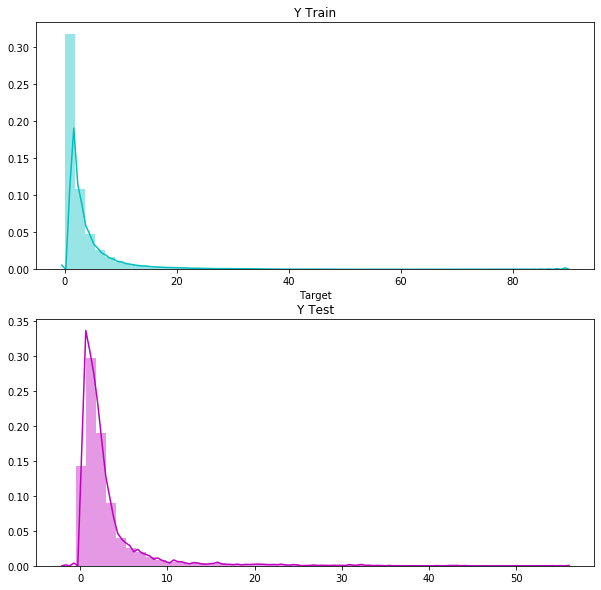

In [69]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

sns.distplot(y_train, color='c', ax=axes[0])
axes[0].set_title('Y Train')

sns.distplot(y_test,  color='m', ax=axes[1])
axes[1].set_title('Y Test')

In [70]:
test_data = 'prediction.sav'
pickle.dump(y_test, open(test_data, 'wb'))